In [228]:
import torch
import numpy as np
import sys
from collections import defaultdict
sys.path.append('..')

In [2]:
from models.vae import VAE
from dataset import get_dataset

use_gpu = torch.cuda.is_available()
device = torch.device('cuda' if use_gpu else 'cpu')
num_gpus = 1

In [247]:
from matplotlib.pyplot import imshow, figure, scatter, colorbar
import
matplotlib.pyplot as plt
from torchvision.utils import make_grid
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

def view_images(t, nrow):
    t_grid = make_grid(t,nrow=nrow)
    imshow(t_grid.cpu().numpy().transpose(1,2,0),interpolation='nearest')

# Model Preparation

In [5]:
# Dataset
data = get_dataset('mnist', '../data')

In [112]:
# Model setup
zdim = 2
x_1, _ = data['train'][0]
dims = list(x_1.shape)
model = VAE(*dims, zdim=zdim)
model.to(device)
print(model)

VAE(
  (stem): Linear(in_features=784, out_features=400, bias=True)
  (gaussian): Linear(in_features=400, out_features=4, bias=True)
  (decoder1): Linear(in_features=2, out_features=400, bias=True)
  (decoder2): Linear(in_features=400, out_features=784, bias=True)
)


In [113]:
chpt = '/data/private/exp/mnist_vae/modelvae_zdim2_batch_size128_num_gpu1_lr0.001/Aug31-2123/checkpoints/epoch_model_10.pth'
state_dict = torch.load(chpt)
model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# Learned MNIST manifold

In [388]:
z_range = 3
z_dim = 10
x, y = torch.meshgrid(torch.linspace(-z_range,z_range,z_dim), torch.linspace(-z_range,z_range,z_dim))
x = x.contiguous().view(-1, 1)
y = y.contiguous().view(-1, 1)
z = torch.cat([x,y], dim=1).to(device)

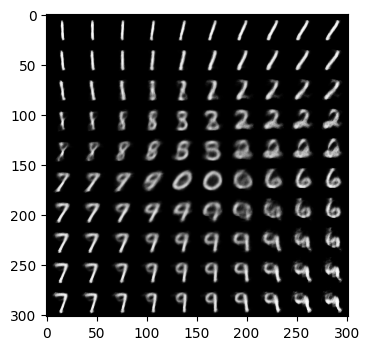

In [389]:
output = model.decode(z).detach().view(-1, 1, 28, 28)
view_images(output, 10)

# Distribution of labeled data

In [380]:
n_sample = 300
sample = defaultdict(list)
loader = torch.utils.data.DataLoader(data['test'], shuffle=True)
for x, y in loader:
    y = y[0].item()
    x = x[0]
    if len(sample[y]) < n_sample:
        sample[y].append(x)
    if all(len(d) == n_sample for d in sample.values()):
        break

In [381]:
s = []
N = len(sample.keys())
for k, v in sample.items():
    v = torch.stack(v).contiguous().view(n_sample, -1).to(device)
    mu, logvar = model.encode(v)
    z = model.reparameterize(mu, logvar).detach().cpu().numpy()
    kk = np.tile(k, [z.shape[0],1])
    s.extend(np.concatenate((z, kk), axis=1))
s = np.array(s)

In [382]:
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = mpl.pyplot.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

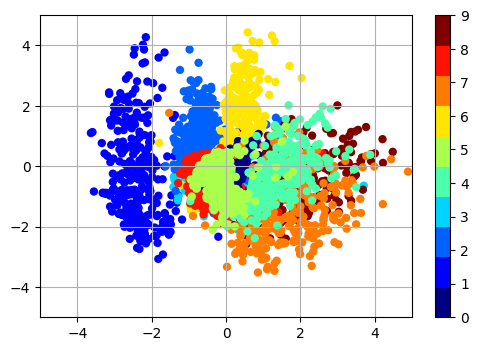

In [383]:
scatter(s[:,0], s[:,1], c=s[:,2].astype(np.int32), marker='o', edgecolor='none', cmap=discrete_cmap(m, 'jet'))
colorbar(ticks=range(m))
axes = plt.gca()
axes.set_xlim([-z_range-3, z_range+3])
axes.set_ylim([-z_range-3, z_range+3])
plt.grid(True)